# Projet 4 : Anticiper les besoins en consommation électrique de bâtiments
*Pierre-Eloi Ragetly*

Ce projet fait parti du parcours *DataScientist* d'OpenClassrooms.

L'objectif principal est de trouver un modèle permettant de prédire **les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l'habitation.**

Pour cela nous disposons des données de la ville de Seattle pour les années 2015 et 2016. Ces données sont à récupérer sur le site kaggle.

# Partie II : Feature Engineering

Ce notebook a pour but de présenter le travail effectué sur l'ingénierie de variables. C'est à dire toutes les transformations effectuées sur les variables afin d'améliorer les performances du modèle. Les données nettoyées (cf Partie I), seront utilisées.

De plus, Un premier tri parmi les variables sera effectué. Celles qui ne seront clairement pas pertinentes pour l'exercice de modélisation, par exemple l'adresse des bâtiments, seront écartées.

In [1]:
# Import des librairies usuelles
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import os

In [2]:
# Change some default parameters of matplotlib using seaborn
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'axes.titleweight': 'bold'})
sns.set(style='ticks')
current_palette = sns.color_palette('RdBu')
sns.set_palette(current_palette)

In [3]:
data_2015 = pd.read_csv('data/data_2015.csv')
data_2016 = pd.read_csv('data/data_2016.csv')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sélection-de-variables" data-toc-modified-id="Sélection-de-variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sélection de variables</a></span></li><li><span><a href="#Analyse-des-variables-clés" data-toc-modified-id="Analyse-des-variables-clés-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyse des variables clés</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-variables-à-prédire" data-toc-modified-id="Analyse-des-variables-à-prédire-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyse des variables à prédire</a></span></li><li><span><a href="#Analyse-de-l'ENERGY-STAR-Score" data-toc-modified-id="Analyse-de-l'ENERGY-STAR-Score-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyse de l'ENERGY STAR Score</a></span></li></ul></li><li><span><a href="#Traitement-des-variables-quantitatives" data-toc-modified-id="Traitement-des-variables-quantitatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Traitement des variables quantitatives</a></span><ul class="toc-item"><li><span><a href="#Traitement-des-variables-de-consommation" data-toc-modified-id="Traitement-des-variables-de-consommation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Traitement des variables de consommation</a></span></li><li><span><a href="#Traitement-des-variables-de-superficie" data-toc-modified-id="Traitement-des-variables-de-superficie-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Traitement des variables de superficie</a></span></li></ul></li><li><span><a href="#Traitement-des-variables-liées-au-type-d'utilisation-des-bâtiments" data-toc-modified-id="Traitement-des-variables-liées-au-type-d'utilisation-des-bâtiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Traitement des variables liées au type d'utilisation des bâtiments</a></span><ul class="toc-item"><li><span><a href="#Création-d'une-table-d'association" data-toc-modified-id="Création-d'une-table-d'association-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Création d'une table d'association</a></span></li><li><span><a href="#Harmonisation-des-utilisations" data-toc-modified-id="Harmonisation-des-utilisations-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Harmonisation des utilisations</a></span></li><li><span><a href="#Traitement-des-données-manquantes" data-toc-modified-id="Traitement-des-données-manquantes-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Traitement des données manquantes</a></span></li></ul></li></ul></div>

## Sélection de variables

Nombre de variables ne sont pas pertinentes pour modéliser la consommation en énergie ou l'émission de CO2. Elles viennent donc polluer le jeu de données et risque d'abaisser l'efficacité de notre modèle, il faut donc les écarter avant de procéder à l'entrainement des modèles.

Parmi elles nous allons trouver des variables renvoyant toutes la même donnée :
- DataYear
- ComplianceStatus
- City
- State

Nous avons aussi des variables qui pourraient s'apparenter à un identifiant. Ayant déja choisi comme identifiant *OSEBuildingID* (cf. Partie I), elles sont donc redondantes et peuvent être écartées sans risquer de perdre de l'information :
- PropertyName
- TaxParcelIdentificationNumber
- Address

D'autres n'auront clairement aucun lien avec les attributs que nous cherchons à modéliser :
- YearsENERGYSTARCertified
- DefaultData

Une variable contient très peu de valeurs renseignée, cinq en tout. De plus, il s'agit de texte, et est donc difficilement utilisable par les algorithmes d'apprentissage automatique classiques :
- Comments

Pour finir, certaines sont redondantes :
- BuildingType (redondante avec PrimaryPropertyType, cf. Partie I)
- CouncilDistrictCode (redondante avec Neighborhood)
- ZipCode (redondante avec Neighborhood)

In [4]:
cols_to_del = ['DataYear',
               'ComplianceStatus',
               'City',
               'State',
               'PropertyName',
               'TaxParcelIdentificationNumber',
               'Address',
               'YearsENERGYSTARCertified',
               'DefaultData',
               'Comments',
               'BuildingType',
               'CouncilDistrictCode',
               'ZipCode']

df = data_2015.copy()
df.set_index('OSEBuildingID', inplace=True)
df.drop(columns=cols_to_del, inplace=True)

## Analyse des variables clés

### Analyse des variables à prédire

La première grandeur que nous cherchons à prédire est l'émission de CO2. Cette grandeur est renseignée dans nos jeux de données par la variable **TotalGHGEmissions**.

La deuxième est la consommation totale d'énergie, elle est renseignée par la variable **SiteEnergyUse(kBtu)**. Nous regarderons aussi sa version normalisée **SiteEnergyUse(kBtu)WN**. Ce WN veut dire *Weather Normalized*, il s'agit de données corrigées basées sur la différence entre la température de l'année en cours et la température moyenne de ces trente dernières années.

Commençons par voir la distribution de ces variables à l'aide d'un histogramme.

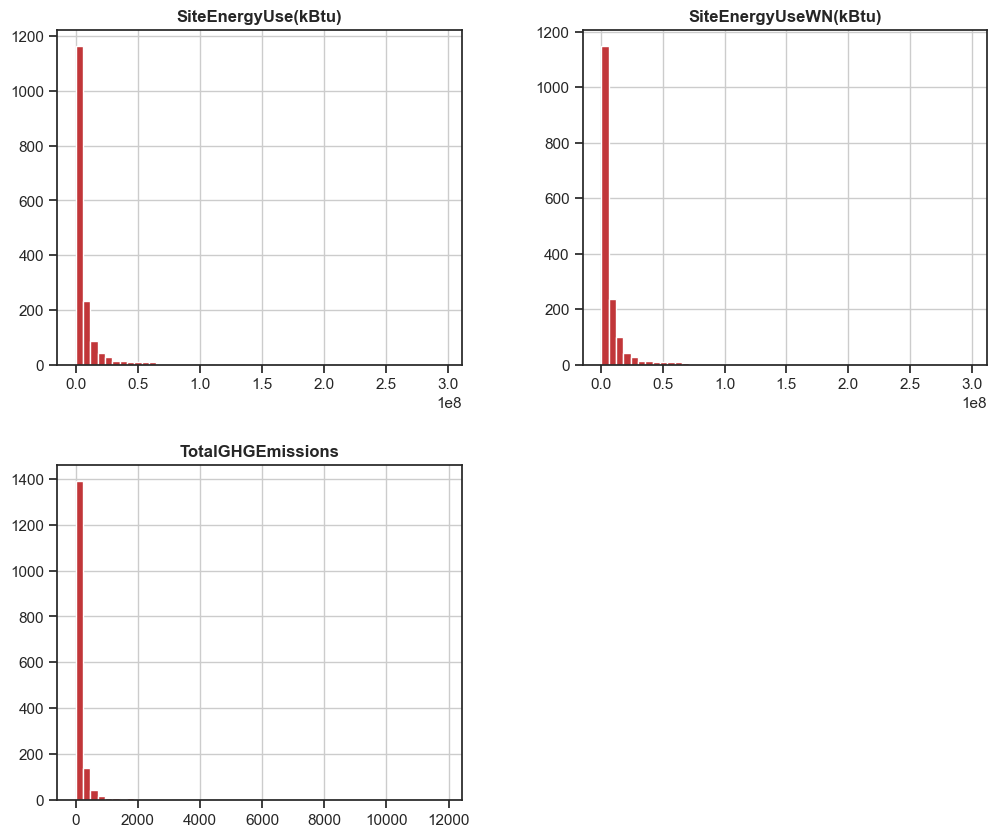

In [5]:
df[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']].hist(bins=50, figsize=(12, 10))
folder_path=os.path.join("charts")
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)
plt.savefig("charts/targets_hist.png", bbox_inches = "tight")
plt.show()

Nous constatons que la distribution est fortement asymétrique pour les deux variables. La forme s'apparente plus à une distribution log normale que normale. Or, en général les algorithmes de Machine Learning (ML) sont plus performants quand les données suivent une distribution normale. Appliquons le log sur les deux variables, et regardons si on obtient une distribution un peu plus proche d'une cloche, forme typique de la distribution normale.

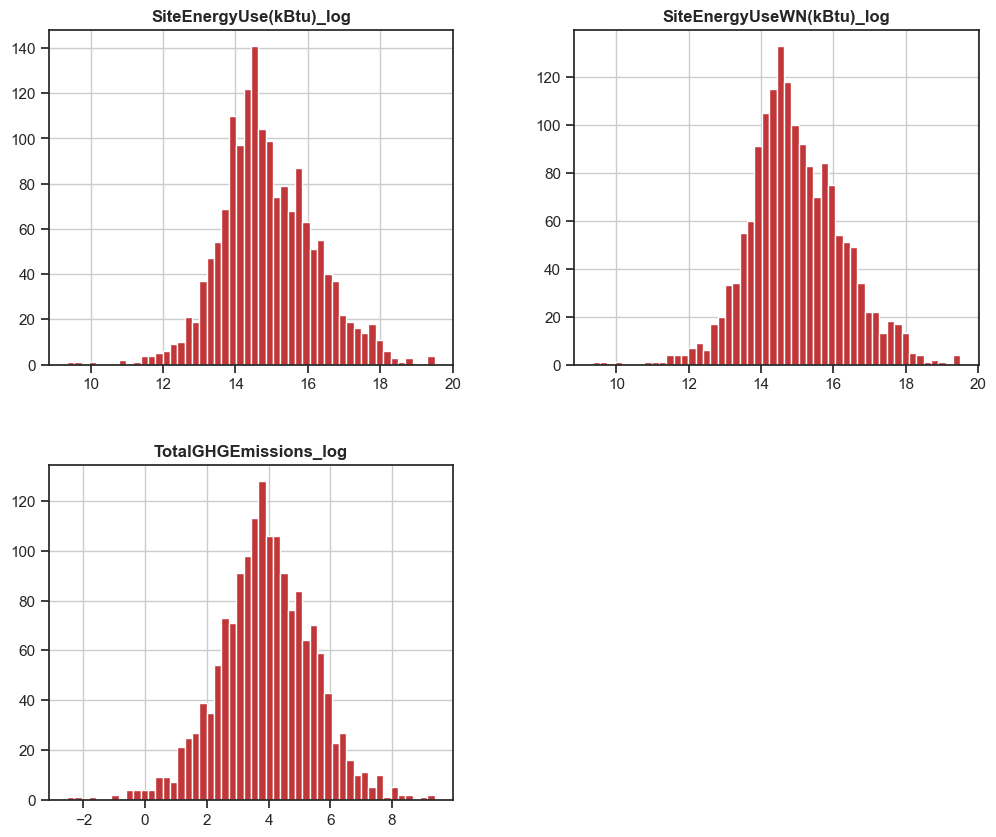

In [6]:
df['SiteEnergyUse(kBtu)_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['SiteEnergyUseWN(kBtu)_log'] = np.log(df['SiteEnergyUseWN(kBtu)'])
df['TotalGHGEmissions_log'] = np.log(df['TotalGHGEmissions'])
df[['TotalGHGEmissions_log', 'SiteEnergyUseWN(kBtu)_log', 'SiteEnergyUse(kBtu)_log']].hist(bins=50, figsize=(12, 10))
plt.savefig("charts/targets_log_hist.png", bbox_inches = "tight")
plt.show()

C'est nettement mieux. **Nous entrainerons donc nos modèles sur le logarithme de ces variables. Puis nous appliquerons l'exponentielle sur les prédictions pour obtenir les bonnes valeurs.**

### Analyse de l'ENERGY STAR Score

Comme nous cherchons aussi à évaluer l'intérêt de l'**ENERGY STAR Score**, il serait pertinent de regarder cette dernière plus en détail avant de nous occuper des autres variables.

Dans notre jeu de donnée, ce score est renseigné par la variable *ENERGYSTARScore*.

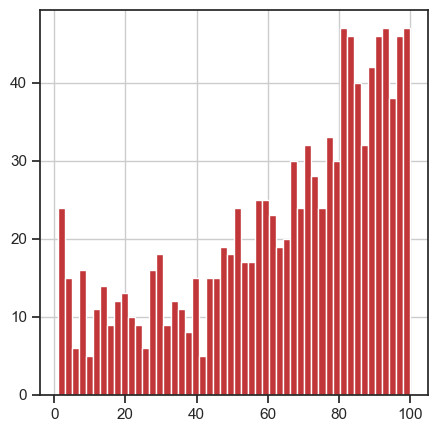

In [7]:
df['ENERGYSTARScore'].hist(bins=50, figsize=(5, 5))
plt.savefig("charts/energystar_hist.png", bbox_inches = "tight")
plt.show()

Nous observons une distribution asymétrique, presque triangulaire. La distribution semble fortement éloignée de celles des variables cibles. Ceci peut être dû au fait que l'Énergie Star Score mesure l'efficacité énergétique. Or, pour mesurer cette dernière il nécessaire de prendre en compte la surface des bâtiments. il serait donc plus pertinent de comparer l'Énergie Star non pas directement à la consommation (ou émission) mais à l'intensité de consommation (ou d'émission), ie. aux variables :
- SiteEUI(kBtu/sf)
- GHGEmissionsIntensity

Un moyen rapide et visuel de comparer ces trois variables est d'utiliser un pair plot, pour cela nous utiliserons la méthode `scatter_matrix()` du module pandas.plotting.

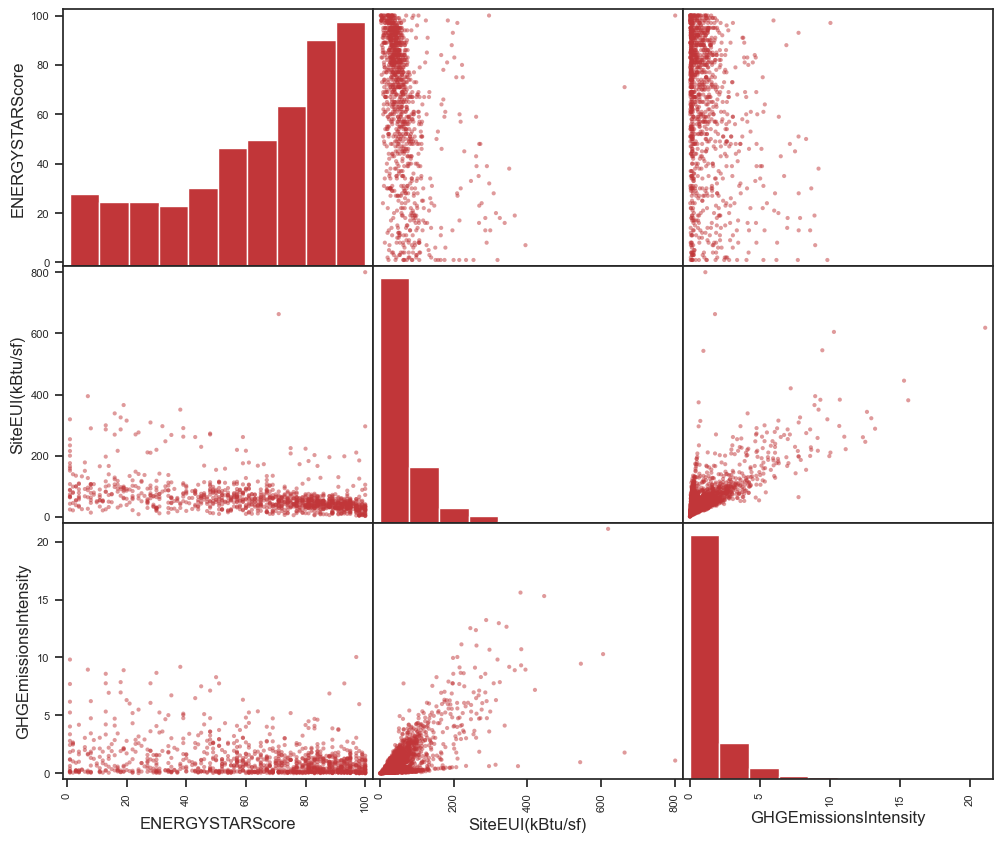

In [8]:
from pandas.plotting import scatter_matrix

features = ['ENERGYSTARScore','SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity']
scatter_matrix(df[features], figsize=(12, 10))
plt.savefig("charts/energystar_pairplot.png", bbox_inches = "tight")
plt.show()

De nouveau nous obtenons des distributions très éloignées. Il serait donc assez surprenant que la variable ENERGY STAR soit clé pour prédire la consommation totale d'énergie ou bien encore l'émission de CO2. 

## Traitement des variables quantitatives

Nous commencerons pas analyser les variables quantitatives, ie. les variables les plus simples à traiter. 

### Traitement des variables de consommation

L'objectif final étant de nous passer des relevés de consommation annuels, nous allons devoir transformer un peu les variables liées à la consommation.

Par exemple au lieu de garder la consommation de chaque type d'énergie nous pourrions calculer la proportion que représente ces énergie dans la consommation totale. Nous pourrions aussi calculer le pourcentage de sources énergétiques primaires (fuel, gaz naturel) et secondaires (vapeur, électricité).

Dans la partie I, nous avions retiré la variable *OtherFuel(kBtu)* car :
1. Elle n'était pas présente dans les données de 2016
2. Elle était systématiquement supérieure aux valeurs obtenues en retranchant la somme des autres sources énergétiques à la consommation totale.

Nous allons commençons par recréer cette variable, en imposant que cette variable soit égale à 0 si la la somme des autres sources énergétiques est supérieure à la consommation totale. Comme on travaillera ensuite avec des ratio, ces cas ne seront pas problématique. Pour l'instant on veut juste éviter d'avoir une consommation négative.

In [9]:
att_conso = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

df['OtherFuel(kBtu)'] = df['SiteEnergyUse(kBtu)'] - df[att_conso].sum(axis=1)
# equalize all negative values to 0
cond = df['OtherFuel(kBtu)'] >= 0
df['OtherFuel(kBtu)'].where(cond, 0, inplace=True)

Nous pouvons maintenant caculer les ratio pour chaque énergie.

In [10]:
att_conso += ['OtherFuel(kBtu)']
for c in att_conso:
    name = c.replace("(kBtu)", "") + "_ratio"
    df[name] = df[c] / df[att_conso].sum(axis=1)

Puis les ratio pour les énergie primaires et secondaires.

In [11]:
df['Primary_ratio'] = df['NaturalGas_ratio'] + df['OtherFuel_ratio']
df['Secondary_ratio'] = df['SteamUse_ratio'] + df['Electricity_ratio']

### Traitement des variables de superficie

Dans nos jeux de données la superficie est désignée par GFA pour Gross Floor Area. Nous avons la superficie totale, ainsi que la superficie dédiée aux bâtiments et celle dédiée aux parkings. Pour les deux dernières, il serait plus pertinent d'avoir les ratio que les superficies absolues.

In [12]:
att_gfa = ['PropertyGFAParking', 'PropertyGFABuilding(s)']
for c in att_gfa:
    name = c + "_ratio"
    df[name] = df[c] / df[att_gfa].sum(axis=1)

## Traitement des variables liées au type d'utilisation des bâtiments

Nous avons plusieurs variables qui renseignent sur l'utilisation de chaque bâtiment. Certaines sont de type quantitatives et nous donnent la superficie allouées aux trois principales utilisations :
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType

D'autres sont qualitatives et permettent de connaître le type d'utilisation :
- PrimaryPropertyType
- ListOfAllPropertyUseTypes
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType

Le but de cette section va être de créer de nouvelles variables qui viendront remplacer les variables listées ci-dessus. Elles permettront de faciliter le travail de modélisation sans perdre d'information. Pour ce faire, nous allons créer une variable par type d'utilisation présent dans *PrimaryPropertyType*. Puis, nous remplirons ces variables en calculant &ndash; à l'aide des trois variables quantitatives ci-dessus &ndash; le pourcentage de la superficie totale alloué à chaque utilisation.

### Création d'une table d'association

L'ensemble des utilisations possibles sont listées dans :
- PrimaryPropertyType
- ListOfAllPropertyUseTypes (qui sert de référence pour toutes les variables finissant par PropertyUseType)

Regardons si ces deux variables possèdent les mêmes modalités.

In [13]:
df['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    284
Other                          258
Non-Refrigerated Warehouse     187
Large Office                   160
K-12 School                    130
Mixed Use Property              99
Retail Store                    95
Worship Facility                72
Hotel                           71
Distribution Center\n           51
Medical Office                  43
Senior Care Community           43
Supermarket/Grocery Store       36
Self-Storage Facility\n         27
College/University              22
Residence Hall/Dormitory        15
Refrigerated Warehouse          13
Restaurant\n                    10
Hospital                        10
SPS-District K-12                4
Distribution Center              2
Laboratory                       1
Self-Storage Facility            1
Restaurant                       1
Name: PrimaryPropertyType, dtype: int64

In [14]:
# Retreive all Property use types
list_of_lists = df['ListOfAllPropertyUseTypes'].dropna().str.split(', ')
values = [item for sublist in list_of_lists for item in sublist]
# Keep only unique items
X = np.array(values)
list_of_use_types = np.unique(X)
print(len(list_of_use_types))
list_of_use_types

69


array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'Bar/Nightclub', 'College/University',
       'Convenience Store without Gas Station', 'Convention Center',
       'Courthouse', 'Data Center', 'Distribution Center', 'Dry Cleaning',
       'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office',
       'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Sales',
       'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel',
       'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center',
       'Locksmith', 'Manufacturing/Industrial Plant', 'Medical Office',
       'Movie Theater', 'Multifamily Housing', 'Museum',
       'Non-Refrigerated Warehouse', 'Office', 'Other',
       'Other - Education', 'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Services',
       'Other - Technology/Science', 'Other - Ut

Nous pouvons remarquer que les types d'utilisation des deux variables ne sont pas les mêmes. Nous allons créer une table d'association qui permettra de passer d'une variable à l'autre.

Pour cela nous allons créer un nouveau *DataFrame* à partir des deux variables *LargestPropertyUseType* et *PrimaryPropertyType*. Puis nous supprimerons les doublons à l'aide de la méthode `drop_duplicates()` de pandas.

In [15]:
associative_df = df[['LargestPropertyUseType', 'PrimaryPropertyType']].dropna()
associative_df.drop_duplicates(inplace=True)
associative_df.reset_index(drop=True, inplace=True)
associative_df.head()

,LargestPropertyUseType,PrimaryPropertyType
0,Hotel,Hotel
1,Police Station,Other
2,Other - Entertainment/Public Assembly,Other
3,Library,Other
4,Fitness Center/Health Club/Gym,Other


Vérifions que chaque entrée de *LargestPropertyUseType* ne possède qu'une valeur pour *PrimaryPropertyType*.

In [16]:
n = associative_df[associative_df['LargestPropertyUseType'].duplicated(keep=False)].shape[0]
print(n)

41


Nous constatons que 41 valeurs de *LargestPropertyUseType* peuvent être associées à plusieurs valeurs pour *PrimaryPropertyType*. Comme c'est un nombre assez limité nous pouvons regarder ces individus plus en détail et ensuite choisir quelle valeur pour PrimaryPropertyType nous voulons garder.

In [17]:
idx = associative_df[associative_df['LargestPropertyUseType'].duplicated(keep=False)].index
associative_df.loc[idx].sort_values('LargestPropertyUseType')

,LargestPropertyUseType,PrimaryPropertyType
58,Bank Branch,Other
72,Bank Branch,Mixed Use Property
54,Distribution Center,Mixed Use Property
27,Distribution Center,Distribution Center\n
4,Fitness Center/Health Club/Gym,Other
65,Fitness Center/Health Club/Gym,Mixed Use Property
61,Hotel,Mixed Use Property
0,Hotel,Hotel
30,Laboratory,Mixed Use Property
38,Laboratory,Other


Nous remarquons que la majorité des problèmes viennent de la modalité *Mixed Use Property*. Il s'agit d'un terme générique dans lequel on peut tout mettre. Il serait préférable de le remplacer par un terme plus explicite.

Il est intéressant de noter que bon nombre des catégories se ressemblent, et que la quasi totalité des valeurs présentes dans la variable *LargestPropertyUseType* et non présentes dans la variable *PrimaryPropertyType* peuvent être regroupées dans la catégorie **other**. Avec cependant une exception pour les bureaux, définis par la modalité **Office** pour *LargestPropertyUseType*, alors que pour *PrimaryPropertyType* ils sont définis par **Small- and Mid-Sized Office** et **Large Office**. Il est assez peu pertinent de distinger les bureaux par taille, sachant que nous avons déjà la variable 'PropertyGFATotal' qui permet de le faire. Nous regrouperons donc tous les bureaux dans la catégorie **Office**.

In [18]:
# drop the \n string at the end of a couple of PrimaryPropertyType modalities
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].str.replace("\n", "")
# replace "Restaurant" by "Restaurant/Bar"
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].str.replace("Restaurant", "Restaurant/Bar")
# gather "Small- and Mid-Sized Office" and "Large Office" modalities in a unique "Office" modality.
office_l = ['Small- and Mid-Sized Office', 'Large Office']
idx = df[df['PrimaryPropertyType'].isin(office_l)].index
df.loc[idx, 'PrimaryPropertyType'] = "Office"
# Recreate the associative array
associative_df = df[['LargestPropertyUseType', 'PrimaryPropertyType']].dropna()
associative_df.drop_duplicates(inplace=True)
associative_df.reset_index(drop=True, inplace=True)
# drop the "Mixed Use Property" modality
idx = associative_df[associative_df['PrimaryPropertyType']=="Mixed Use Property"].index
associative_df.drop(index=idx, inplace=True)
# Add a row at the end
associative_df = associative_df.append({'LargestPropertyUseType': "Other - Restaurant/Bar",
                      'PrimaryPropertyType': "Restaurant/Bar"}, ignore_index=True)
# Rename LargestPropertyUseType by PropertyUseType
associative_df.rename(columns={'LargestPropertyUseType': 'PropertyUseType'}, inplace=True)

In [19]:
associative_df.tail()

,PropertyUseType,PrimaryPropertyType
50,Movie Theater,Other
51,Outpatient Rehabilitation/Physical Therapy,Other
52,"Personal Services (Health/Beauty, Dry Cleaning...",Other
53,Pre-school/Daycare,Other
54,Other - Restaurant/Bar,Restaurant/Bar


In [20]:
n = associative_df[associative_df['PropertyUseType'].duplicated(keep=False)].shape[0]
print(n)

0


La table d'association est prête et peut maintenant être utilisée

### Harmonisation des utilisations

Nous pouvons maintenant utiliser la table d'association pour transformer les variables :
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType

In [21]:
cols_UseType = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
for c in cols_UseType:
    df[c] = (pd.merge(df[c], associative_df, how='left', left_on=c, right_on='PropertyUseType')
               .PrimaryPropertyType
               .tolist())

### Traitement des données manquantes

In [22]:
cols = ['PrimaryPropertyType',
         'LargestPropertyUseType',
         'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']
data_2015[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   PrimaryPropertyType           1635 non-null   object
 1   LargestPropertyUseType        1568 non-null   object
 2   SecondLargestPropertyUseType  802 non-null    object
 3   ThirdLargestPropertyUseType   320 non-null    object
dtypes: object(4)
memory usage: 51.2+ KB


In [23]:
cols = ['PrimaryPropertyType',
         'LargestPropertyUseType',
         'SecondLargestPropertyUseType',
         'ThirdLargestPropertyUseType']
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 1 to 50038
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   PrimaryPropertyType           1635 non-null   object
 1   LargestPropertyUseType        1568 non-null   object
 2   SecondLargestPropertyUseType  777 non-null    object
 3   ThirdLargestPropertyUseType   297 non-null    object
dtypes: object(4)
memory usage: 143.9+ KB


In [24]:
data_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Latitude', 'Longitude',
       'Address', 'City', 'State', 'ZipCode'],
      dtyp